# Метод опорных векторов. Ядра.


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
#plots
import matplotlib.pyplot as plt
%matplotlib inline
#beautiful plots
import seaborn as sns
#linear regression
import statsmodels.api as sm
#set style for plots
sns.set_style('darkgrid')
#off the warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Метод Опорных Векторов и Задача Регрессии

### Набор данных с ценами на недвижимость (*train.csv*)
* Ранее мы искали линейную зависимость между зависимой переменной (Y, Sale Price) и некоторым набором признаков (X)

Подробнее о наборе данных https://www.kaggle.com/datasets/lespin/house-prices-dataset

In [2]:
cols=['Id', 'MSSubClass', 'LotArea', 'OverallQual',\
      'OverallCond', 'YearBuilt', 'YearRemodAdd',\
      'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',\
     'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',\
     'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',\
     'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',\
     'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',\
     'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [3]:
data = pd.read_csv('train.csv', index_col=0, usecols=cols)
data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,150,856,856,854,...,0,61,0,0,0,0,0,2,2008,208500
2,20,9600,6,8,1976,1976,284,1262,1262,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,11250,7,5,2001,2002,434,920,920,866,...,0,42,0,0,0,0,0,9,2008,223500
4,70,9550,7,5,1915,1970,540,756,961,756,...,0,35,272,0,0,0,0,2,2006,140000
5,60,14260,8,5,2000,2000,490,1145,1145,1053,...,192,84,0,0,0,0,0,12,2008,250000


#### Корреляционная матрица:

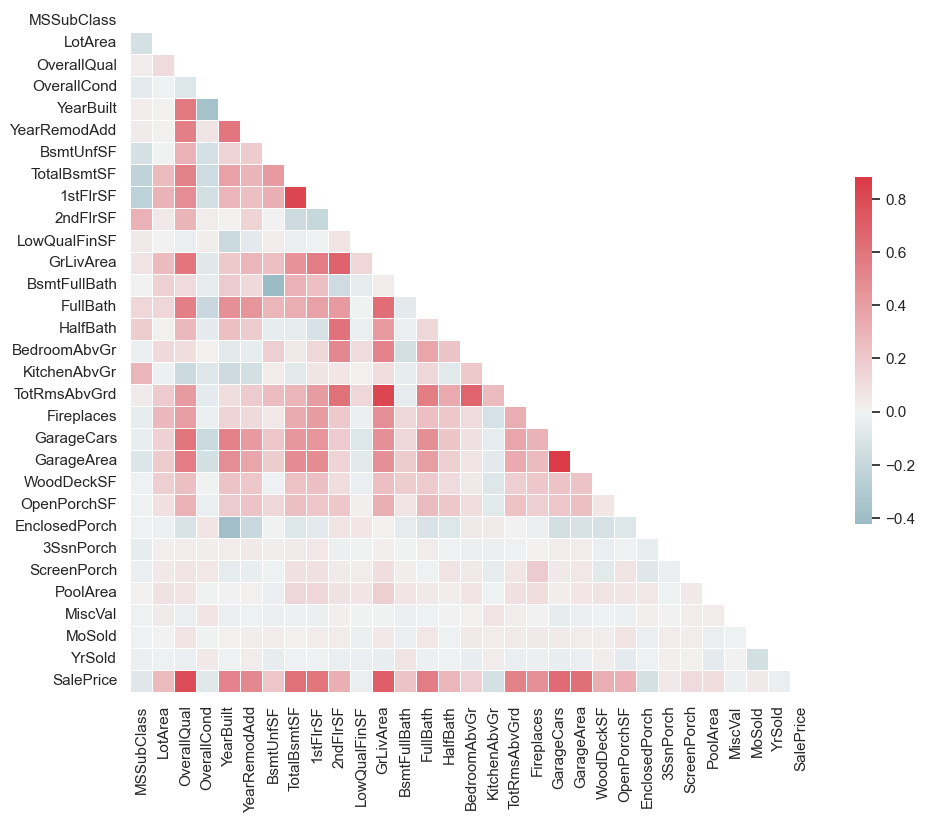

In [4]:
dt=data.copy()
sns.set(style="white")

# Вычислить корреляционную матрицу
corr = dt.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Наилучшая модель, которая у нас получилась, выглядела так:

In [5]:
X = data.drop(['SalePrice', 'GrLivArea'], axis=1)
Y = data.SalePrice

X = sm.add_constant(X)

model = sm.OLS(Y, X)

results = model.fit()

In [6]:
cols2 = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF',\
         'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',\
 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',\
 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [7]:
alpha = 0.05

# исключение признаков
while results.pvalues[results.pvalues > 0.05].shape[0] > 0:
    use_cols=results.pvalues[results.pvalues != results.pvalues.max()].keys().tolist()
    X = X[use_cols]
    Y = data.SalePrice

    model = sm.OLS(Y, X)

    results = model.fit()

In [8]:
print(results.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.968     
Dependent Variable:     SalePrice        AIC:                         34726.4699
Date:                   2024-10-26 20:04 BIC:                         34821.6214
No. Observations:       1460             Log-Likelihood:              -17345.   
Df Model:               18               F-statistic:                 2482.     
Df Residuals:           1442             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.969            Scale:                       1.2360e+09
---------------------------------------------------------------------------------
                    Coef.      Std.Err.     t     P>|t|      [0.025      0.975]  
---------------------------------------------------------------------------------
MSSubClass         -154.9909    26.0905  -5.9405  0.0000    -206.1703   -103.8115
LotArea               0.4183     0.1004   4.1667 

### Давайте попробуем смоделировать зависимость при помощи линейного SVM

* Какие параметры есть у sklearn-реализации SVR?

In [9]:
SVR?

Init signature:
SVR(
    *,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    C=1.0,
    epsilon=0.1,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1,
)
Docstring:     
Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

The implementation is based on libsvm. The fit time complexity
is more than quadratic with the number of samples which makes it hard
to scale to datasets with more than a couple of 10000 samples. For large
datasets consider using :class:`~sklearn.svm.LinearSVR` or
:class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer or
other :ref:`kernel_approximation`.

Read more in the :ref:`User Guide <svm_regression>`.

Parameters
----------
kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable,          default='rbf'
     Specifies the kernel type to be used in the algorithm.
     If none 

* Зададим параметры для SVR "из коробки":

In [10]:
regressor = SVR(kernel='linear', verbose=True)

In [11]:
X = data.drop('SalePrice', axis=1)
model = regressor.fit(X,Y)

[LibSVM]

In [12]:
predictions = model.predict(X)

In [13]:
sklearn.metrics.r2_score(Y, predictions)

0.7332931748395889

In [14]:
model.score(X,Y)

0.7332931748395889

* Можно ли сделать "лучше", не переходя к ядрам? 

Попробуем варьировать дефолтные параметры:

In [15]:
C = [0.1, 1, 10, 50, 100]
epsilon = [0.1, 1, 10]

In [16]:
regressor = SVR(kernel='linear', C=5, epsilon=0.01)
model = regressor.fit(X,Y)
predictions = model.predict(X)
sklearn.metrics.r2_score(Y, predictions)

0.7440140726936351

* А теперь давайте посмотрим, как изменится ситуация при использовании ядер:

### SVM c ядрами

* для некоторых ядер требуется "стандартизировать" данные
* два основных способа: нормализация данных и преобразование к интервалу [0, 1]

In [17]:
# нормализация
def scale(df):
    return ((df - df.mean()) / df.std())

# преобразование к интервалу [0, 1]
def scaling_to_zero_one(df):
    return (df - df.min()) / (df.max() - df.min())

* что будет без нормализации? **rbf-ядро**

In [18]:
regressor = SVR(kernel='rbf')
model = regressor.fit(X,Y)
predictions = model.predict(X)
sklearn.metrics.r2_score(Y, predictions)

-0.050470839488731434

* а с нормализацией:

In [19]:
regressor = SVR(kernel='rbf')
model = regressor.fit(scaling_to_zero_one(X),scaling_to_zero_one(Y))
predictions = model.predict(scaling_to_zero_one(X))
sklearn.metrics.r2_score(scaling_to_zero_one(Y), predictions)

0.8254780658330497

In [20]:
regressor = SVR(kernel='rbf')
model = regressor.fit(scale(X),scale(Y))
predictions = model.predict(scale(X))
sklearn.metrics.r2_score(scale(Y), predictions)

0.9077424360754246

* другие ядра

In [21]:
SVR?

Init signature:
SVR(
    *,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    C=1.0,
    epsilon=0.1,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1,
)
Docstring:     
Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

The implementation is based on libsvm. The fit time complexity
is more than quadratic with the number of samples which makes it hard
to scale to datasets with more than a couple of 10000 samples. For large
datasets consider using :class:`~sklearn.svm.LinearSVR` or
:class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer or
other :ref:`kernel_approximation`.

Read more in the :ref:`User Guide <svm_regression>`.

Parameters
----------
kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable,          default='rbf'
     Specifies the kernel type to be used in the algorithm.
     If none 

In [22]:
regressor = SVR(kernel='poly')
model = regressor.fit(scale(X),scale(Y))
predictions = model.predict(scale(X))
sklearn.metrics.r2_score(scale(Y), predictions)

0.9555114888611512

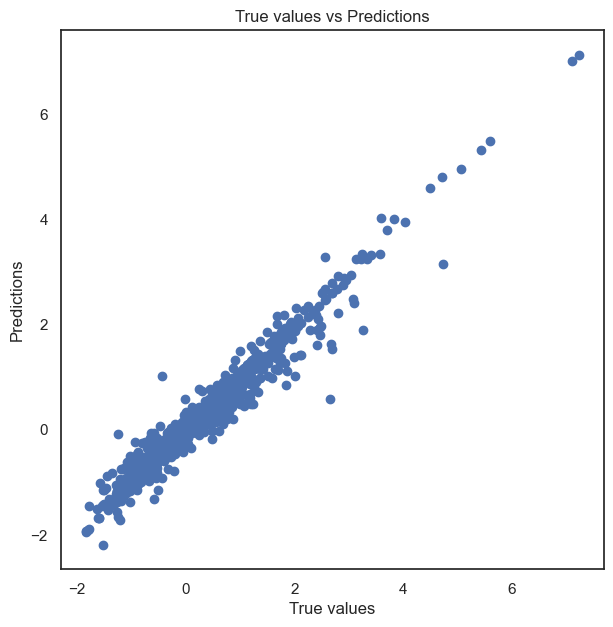

In [23]:
plt.figure(figsize=(7,7))
plt.scatter(scale(Y), predictions)
#plt.plot(scaling_to_zero_one(np.arange(Y.shape[0])), scaling_to_zero_one(np.arange(Y.shape[0])))
plt.title('True values vs Predictions')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

In [24]:
regressor = SVR(kernel='poly')
model = regressor.fit(scaling_to_zero_one(X),scaling_to_zero_one(Y))
predictions = model.predict(scaling_to_zero_one(X))
sklearn.metrics.r2_score(scaling_to_zero_one(Y), predictions)

0.83993836442869

In [25]:
regressor = SVR(kernel='sigmoid')
model = regressor.fit(scale(X),scale(Y))
predictions = model.predict(scale(X))
sklearn.metrics.r2_score(scale(Y), predictions)

-61.09620658178995

In [26]:
regressor = SVR(kernel='sigmoid')
model = regressor.fit(scaling_to_zero_one(X),scaling_to_zero_one(Y))
predictions = model.predict(scaling_to_zero_one(X))
sklearn.metrics.r2_score(scaling_to_zero_one(Y), predictions)

-15152.506012178184

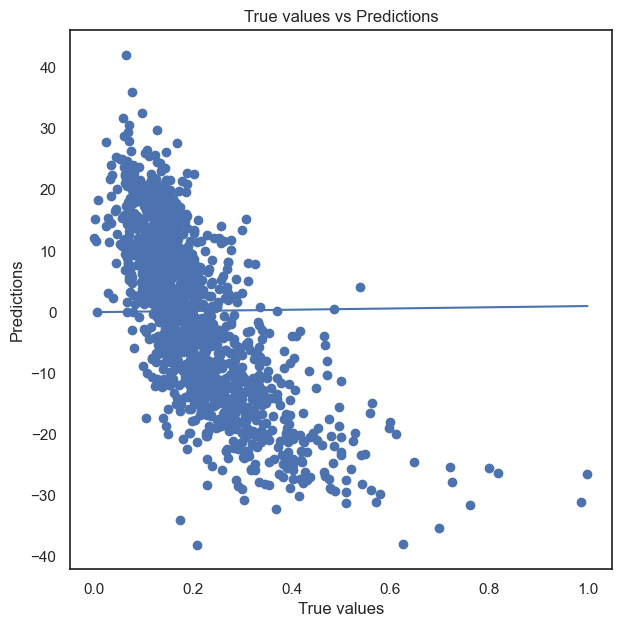

In [27]:
plt.figure(figsize=(7,7))
plt.scatter(scaling_to_zero_one(Y), predictions)
plt.plot(scaling_to_zero_one(np.arange(Y.shape[0])), scaling_to_zero_one(np.arange(Y.shape[0])))
plt.title('True values vs Predictions')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

### **Задание 1**

Подобрать конфигурацию SVR (с ядром или без ядра), которая наилучшим образом моделирует существующую зависимость.
* подобрать ядро
* подобрать параметры

## 2. Метод опорных векторов для задачи классификации

В прошлый раз мы работали с набором данных "ирисы":

In [28]:
X, Y = sklearn.datasets.load_iris(return_X_y=True)
names = ['sepal length', 'sepal width', 'petal length', 'petal width']
classes = ['setosa', 'versicolor', 'virginica']

#создать объект pandas

X = pd.DataFrame(X, columns=names)
X.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Целевая переменная уже закодирована:

    * 0 - Setosa

    * 1 - Versicolor
    
    * 2 - Verginica


Корреляция:

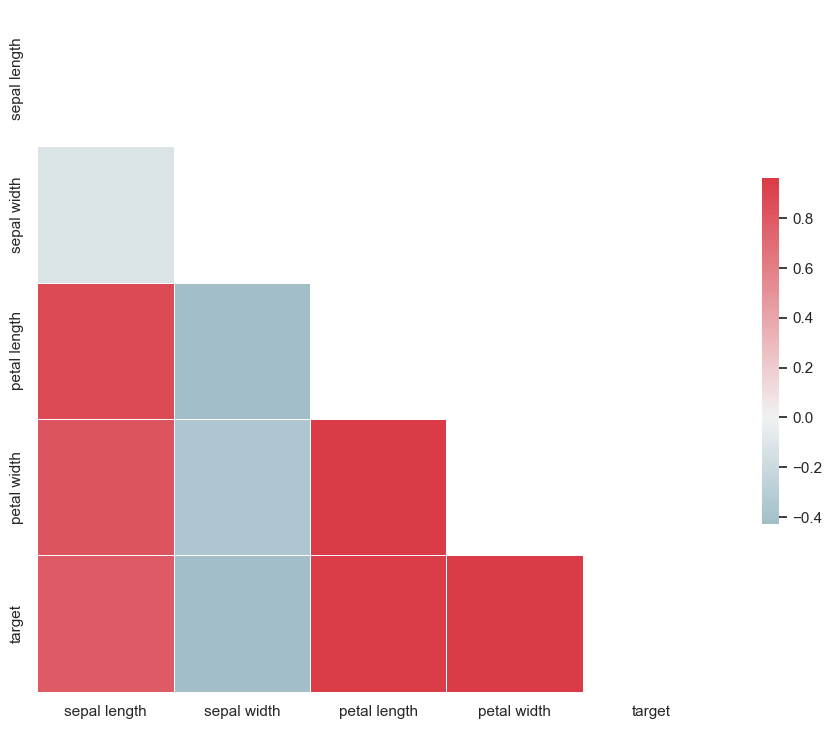

In [29]:
dt=pd.concat([X,pd.DataFrame(Y, columns=['target'])], axis=1)
sns.set(style="white")

corr = dt.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Графики

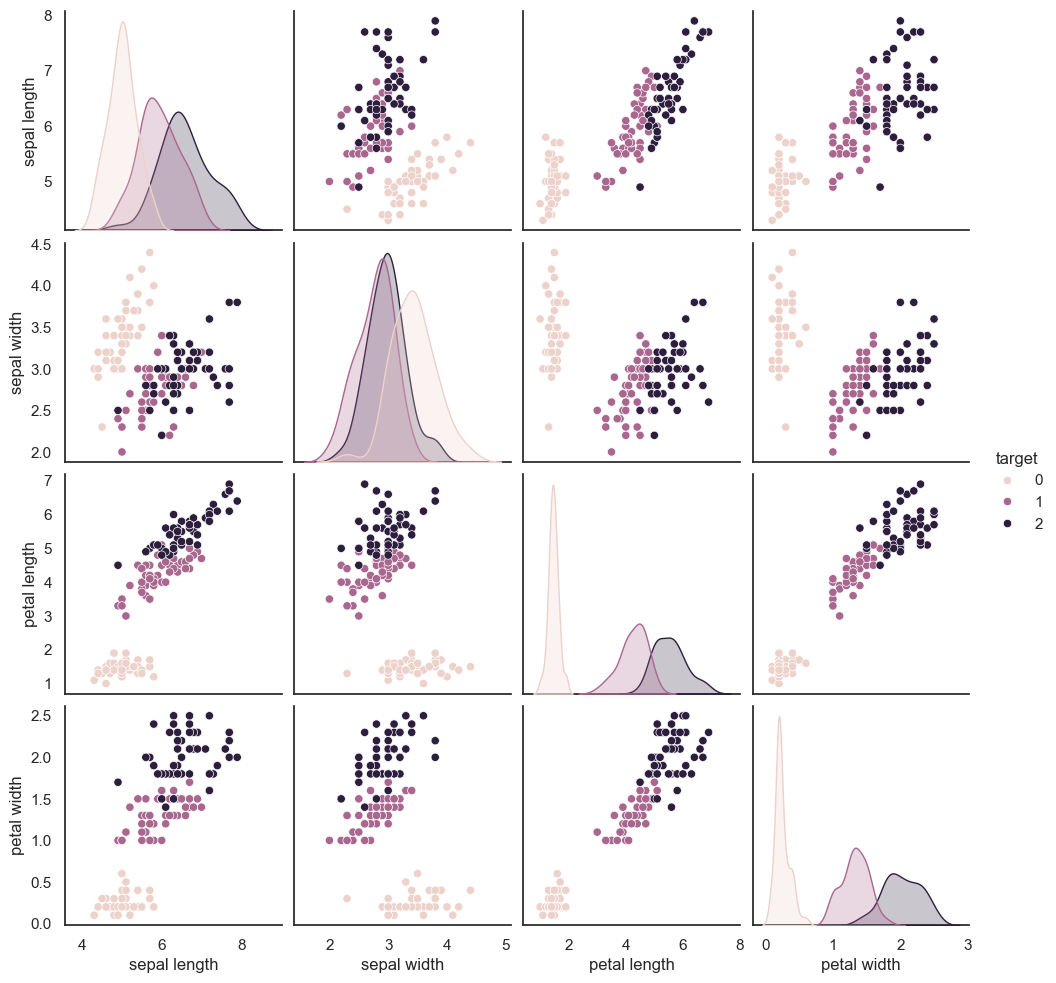

In [30]:
sns.pairplot(dt, kind='scatter', hue='target')
plt.show()

**Обычная логистическая регрессия**

In [31]:
#from sklearn import metrics 
logit = sm.MNLogit(Y, X)
result = logit.fit()
preds=np.argmax(result.predict(X).values,axis=1)
accuracy_score(Y,preds)

         Current function value: 0.072266
         Iterations: 35


0.9666666666666667

**Логистическая регрессия с L1 регуляризацией**

In [32]:
from sklearn import linear_model
model=sklearn.linear_model.LogisticRegression(penalty='l1',multi_class='multinomial', solver='saga').fit(X,Y)
preds=model.predict(X)
accuracy_score(Y, preds)

0.98

**Логистическая регрессия с L2 регуляризацией**

In [33]:
from sklearn import linear_model
model=sklearn.linear_model.LogisticRegression(penalty='l2',multi_class='multinomial', solver='saga', fit_intercept=True).fit(X,Y)
preds=model.predict(X)
accuracy_score(Y, preds)

0.9866666666666667

### SVC

In [34]:
clf = sklearn.svm.SVC(kernel='linear')

In [35]:
model = clf.fit(X,Y)

In [36]:
predictions = model.predict(X)

In [37]:
model.score(X,Y)

0.9933333333333333

In [38]:
accuracy_score(Y, predictions)

0.9933333333333333

* Что с ядрами?

In [39]:
clf = sklearn.svm.SVC(kernel='rbf')
model = clf.fit(X, Y)
predictions = model.predict(X)
accuracy_score(Y, predictions)

0.9733333333333334

* Почему "работает" без стандартизации?

In [40]:
X.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [41]:
X.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


* А если добавить стандартизацию?

In [42]:
clf = sklearn.svm.SVC(kernel='rbf')
model = clf.fit(scale(X), Y)
predictions = model.predict(scale(X))
accuracy_score(Y, predictions)

0.9733333333333334

In [43]:
clf = sklearn.svm.SVC(kernel='rbf')
model = clf.fit(scaling_to_zero_one(X), Y)
predictions = model.predict(scaling_to_zero_one(X))
accuracy_score(Y, predictions)

0.98

* А теперь другие ядра:

In [44]:
clf = sklearn.svm.SVC(kernel='poly')
model = clf.fit(X, Y)
predictions = model.predict(X)
accuracy_score(Y, predictions)

0.9733333333333334

In [45]:
clf = sklearn.svm.SVC(kernel='poly')
model = clf.fit(scale(X), Y)
predictions = model.predict(scale(X))
accuracy_score(Y, predictions)

0.9533333333333334

In [46]:
clf = sklearn.svm.SVC(kernel='poly')
model = clf.fit(scaling_to_zero_one(X), Y)
predictions = model.predict(scaling_to_zero_one(X))
accuracy_score(Y, predictions)

0.98

In [47]:
clf = sklearn.svm.SVC(kernel='sigmoid')
model = clf.fit(X, Y)
predictions = model.predict(X)
accuracy_score(Y, predictions)

0.07333333333333333

In [48]:
clf = sklearn.svm.SVC(kernel='sigmoid')
model = clf.fit(scale(X), Y)
predictions = model.predict(scale(X))
accuracy_score(Y, predictions)

0.8866666666666667

In [49]:
clf = sklearn.svm.SVC(kernel='sigmoid')
model = clf.fit(scaling_to_zero_one(X), Y)
predictions = model.predict(scaling_to_zero_one(X))
accuracy_score(Y, predictions)

0.25333333333333335

### **Задание 2**

Подберите параметры для SVC, дающие наибольшую точность (accuracy score)

### Анализ результатов

Прогнозирование:

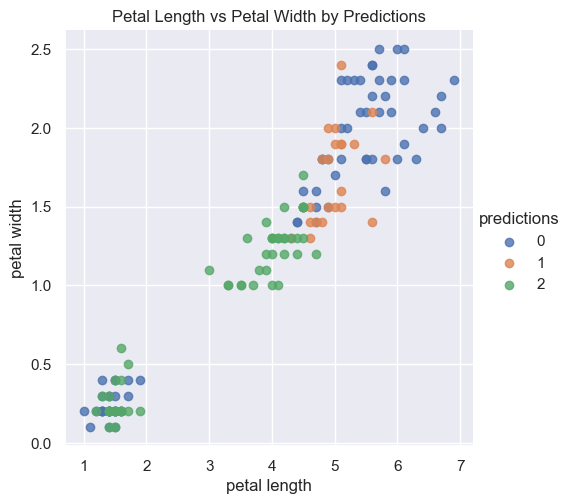

In [53]:
# Анализ результатов
df = pd.concat([X, pd.DataFrame(predictions, columns=['predictions'])], axis=1)
sns.set_style('darkgrid')

# Использование lmplot с именованными параметрами
sns.lmplot(data=df, x='petal length', y='petal width', hue='predictions', scatter=True, fit_reg=False)
plt.title('Petal Length vs Petal Width by Predictions')
plt.show()


**Матрица ошибок (Confusion matrix)**

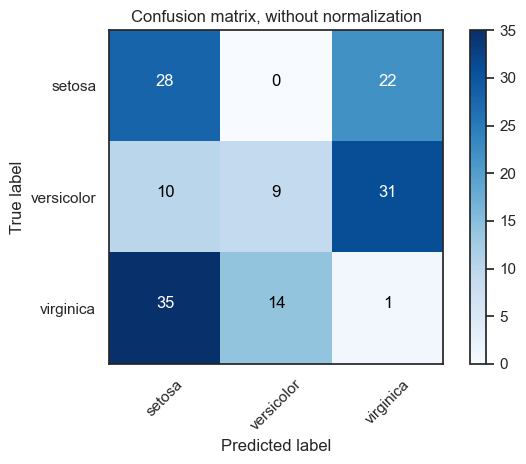

In [51]:
import itertools
from sklearn.metrics import confusion_matrix

sns.set_style('white')

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(Y, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,\
                      title='Confusion matrix, without normalization')

plt.show()